In [2]:
import os
import glob
import numpy as np
import time
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import h5py as h5
from scipy import signal
import utils
import parser_ops
from multiprocessing import Pool
from multiprocessing import cpu_count
from IPython.display import clear_output
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
parser = parser_ops.get_parser()
args = parser.parse_args(args=[])

%matplotlib inline

2025-06-17 11:29:44.200247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 11:29:44.250070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 11:29:45.980753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


###  Plot loss curves 

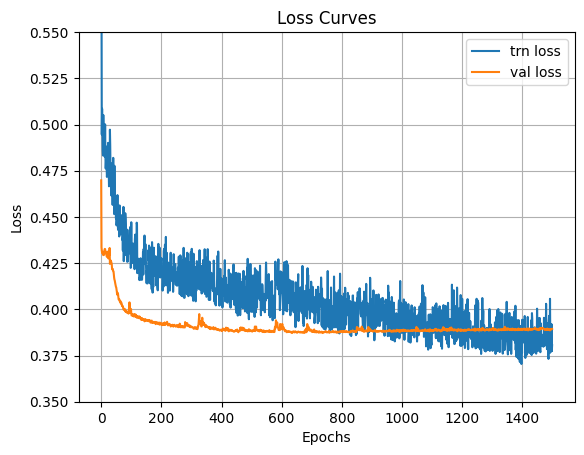

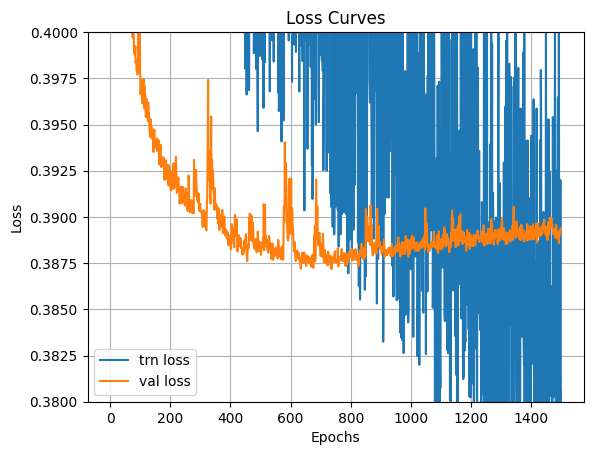

1500 [0.38056418]
1500 [0.38938403]


In [26]:
file_dir = os.path.join(os.getcwd(),'saved_models')

saved_model_name = 'ZS_SSL_tbme_tutorial_Rate4_100reps'

saved_model_dir = os.path.join(file_dir,saved_model_name)
trn_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['trn_loss']
val_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['val_loss']
plt.plot(np.asarray(trn_loss).T)
plt.plot(np.asarray(val_loss).T)
plt.ylim([0.35, 0.55])
plt.title('Loss Curves'), plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend(['trn loss', 'val loss'])
plt.grid()
plt.show()

zoom_plot1 = 1

if zoom_plot1 == 1:

    file_dir = os.path.join(os.getcwd(),'saved_models')
    saved_model_name_current = 'ZS_SSL_tbme_tutorial_Rate1_50reps'
    saved_model_dir_current = os.path.join(file_dir,saved_model_name_current)
    trn_loss_current = sio.loadmat(os.path.join(saved_model_dir_current,'TrainingLog.mat'))['trn_loss']
    val_loss_current = sio.loadmat(os.path.join(saved_model_dir_current,'TrainingLog.mat'))['val_loss']
    plt.plot(np.asarray(trn_loss).T)
    plt.plot(np.asarray(val_loss).T)
    plt.ylim([0.38, 0.40])
    plt.title('Loss Curves'), plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend(['trn loss', 'val loss'])
    plt.grid()
    plt.show()
    
print(len(trn_loss[0,:]), np.asarray(trn_loss)[...,-1])
print(len(val_loss[0,:]), np.asarray(val_loss)[...,-1])

### Load the data and generate images

In [5]:
args.nrow_GLOB, args.ncol_GLOB, args.ncoil_GLOB, args.necho_GLOB = 320, 320, 20, 1

args.data_dir = 'data/'

data_list = glob.glob(args.data_dir + "/*.mat")
data_list = sorted(data_list, key=os.path.getmtime)
nslice_GLOB = len(data_list)

data = sio.loadmat(data_list[0])
original_mask = data['mask']
test_mask = np.complex64(original_mask)

sens_maps = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.ncoil_GLOB), dtype=np.complex64)

def load_data_parl(ss):
    tic = time.time()
    data = sio.loadmat(data_list[ss])
    kspace_tmp_parl, sens_maps_parl = data['kspace'], data['sens_maps']
    kspace_max_parl = np.max(np.abs(kspace_tmp_parl[:]))
    toc = time.time() - tic
    clear_output(wait=True)
    print("..... Loading data:", ss + 1, "/", nslice_GLOB, ", elapsed_time = ""{:.2f}".format(toc))
    return kspace_max_parl, sens_maps_parl

num_parallel = min([int(cpu_count()/4), nslice_GLOB])
pool = Pool(num_parallel)
kspace_max_parl, sens_maps_parl = zip(*pool.map(load_data_parl, range(nslice_GLOB)))
pool.close()

for ss in range(nslice_GLOB):
    sens_maps[ss, ...] = sens_maps_parl[ss]
kspace_max = max(kspace_max_parl)
del kspace_max_parl, sens_maps_parl

print('..... k-space max ')
print(kspace_max)

nw_input = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB * 2), dtype=np.float32)

def make_data_reps(ss):
    tic = time.time()
    data = sio.loadmat(data_list[ss])
    kspace_test = data['kspace'] / kspace_max

    nw_input_reps = np.empty((args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB * 2), dtype=np.float32)

    for ee in range(args.necho_GLOB):
        nw_input_reps[..., ee * 2:(ee + 1) * 2] = utils.complex2real(utils.sense1(kspace_test[..., ee], sens_maps[ss, ...])[np.newaxis])

    toc = time.time() - tic
    clear_output(wait=True)
    print("..... Generate validation data:", ss + 1, "/", nslice_GLOB, ", elapsed_time = ""{:.2f}".format(toc))
    return nw_input_reps, _

num_parallel = min([int(cpu_count()/4), nslice_GLOB])
pool = Pool(num_parallel)
# nw_input_reps = list(zip(*pool.map(make_data_reps, range(nslice_GLOB))))
nw_input_reps, _ = zip(*pool.map(make_data_reps, range(nslice_GLOB)))
pool.close()
for ss in range(nslice_GLOB):
    # nw_input[ss, ...] = np.array(nw_input_reps)[:, ss, ...]
    nw_input[ss, ...] = nw_input_reps[ss]
del nw_input_reps

print("done")

..... Loading data: 1 / 1 , elapsed_time = 0.08
..... k-space max 
0.010194803409381621
..... Generate validation data: 1 / 1 , elapsed_time = 0.24
done


### Load the model and perform the reconstruction

In [27]:
tf.compat.v1.reset_default_graph()
loadChkPoint = tf.compat.v1.train.latest_checkpoint(saved_model_dir)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
zs_ssl_recon = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB * 2), dtype=np.float32)
with tf.compat.v1.Session(config=config) as sess:
    new_saver = tf.compat.v1.train.import_meta_graph(saved_model_dir + '/model_test.meta')
    new_saver.restore(sess, loadChkPoint)

    # ..................................................................................................................
    graph = tf.compat.v1.get_default_graph()
    nw_output = graph.get_tensor_by_name('nw_output:0')
    nw_kspace_output = graph.get_tensor_by_name('nw_kspace_output:0')
    mu_param = graph.get_tensor_by_name('mu:0')
    x0_output = graph.get_tensor_by_name('x0:0')
    all_intermediate_outputs = graph.get_tensor_by_name('all_intermediate_outputs:0')

    # ...................................................
    trn_maskP = graph.get_tensor_by_name('trn_mask:0')
    loss_maskP = graph.get_tensor_by_name('loss_mask:0')
    nw_inputP = graph.get_tensor_by_name('nw_input:0')
    sens_mapsP = graph.get_tensor_by_name('sens_maps:0')
    weights = sess.run(tf.compat.v1.global_variables())
    #...................................................
    # dataDict = {nw_inputP: nw_input[np.newaxis], trn_maskP: test_mask[np.newaxis], loss_maskP: test_mask[np.newaxis], sens_mapsP: np.transpose(sens_maps[np.newaxis], (0, 3, 1, 2)), basisP: basis[np.newaxis]}
    for ss in range(nslice_GLOB):
        tic = time.time()
        dataDict = {nw_inputP: nw_input[ss][np.newaxis], \
                    trn_maskP: test_mask[np.newaxis], \
                    loss_maskP: test_mask[np.newaxis], \
                    sens_mapsP: np.transpose(sens_maps, (0, 3, 1, 2))[ss][np.newaxis]}
        zs_ssl_recon[ss, ...], *_ = sess.run([nw_output, nw_kspace_output, x0_output, all_intermediate_outputs, mu_param], feed_dict=dataDict)
        toc = time.time() - tic
        clear_output(wait=True)
        print("..... Generate output data:", ss + 1, "/", nslice_GLOB, ", elapsed_time = ""{:.2f}".format(toc))

print("Used checkpoint for test:", loadChkPoint)
print("done")

..... Generate output data: 1 / 1 , elapsed_time = 2.51
Used checkpoint for test: /autofs/cluster/berkin/yohan/python_code/ZS_SSL_TBME_tutorial/saved_models/ZS_SSL_tbme_tutorial_Rate4_100reps/model-736
done


In [28]:
img_res_input = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB), dtype=np.complex64)
img_res_zsssl = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB), dtype=np.complex64)
for ss in range(nslice_GLOB):
    tic = time.time()
    for ee in range(args.necho_GLOB):
        img_res_input[ss, ..., ee] = utils.real2complex(nw_input[ss, ...,ee*2:(ee+1)*2])
        img_res_zsssl[ss, ..., ee] = utils.real2complex(zs_ssl_recon[ss, ...,ee*2:(ee+1)*2])
    toc = time.time() - tic
    clear_output(wait=True)
    print("..... Generate output data:", ss + 1, "/", nslice_GLOB, ", elapsed_time = ""{:.2f}".format(toc))

print("done")

..... Generate output data: 1 / 1 , elapsed_time = 0.00
done


### Visualize the reconstruction

(<Axes: title={'center': 'Zero-Shot SSL Images'}>,
 Text(0.5, 1.0, 'Zero-Shot SSL Images'))

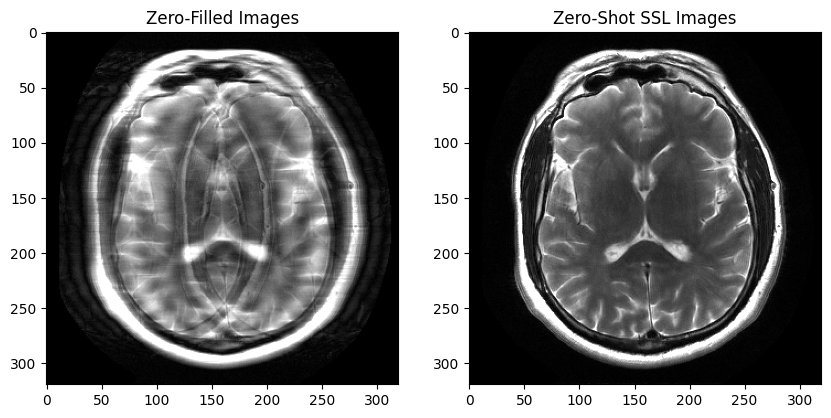

In [29]:
v_img_res_zsssl = np.empty((nslice_GLOB, args.nrow_GLOB, args.ncol_GLOB, args.necho_GLOB), dtype=np.float32)

idx_ax = 0 # 150

for ee in range(args.necho_GLOB):
    v_img_res_input_ax_tmp = np.abs(img_res_input[idx_ax, ..., ee]) / np.max(np.abs(img_res_input[idx_ax, ..., ee])[:])
    v_img_res_zsssl_ax_tmp = np.abs(img_res_zsssl[idx_ax, ..., ee]) / np.max(np.abs(img_res_zsssl[idx_ax, ..., ee])[:])
    
    # v_img_res_input_ax_tmp = np.flip(v_img_res_input_ax_tmp,0)
    # v_img_res_zsssl_ax_tmp = np.flip(v_img_res_zsssl_ax_tmp,0)
    
    if ee == 0:
        v_img_res_input_ax = np.copy(v_img_res_input_ax_tmp)
        v_img_res_zsssl_ax = np.copy(v_img_res_zsssl_ax_tmp)
    else:
        v_img_res_input_ax = np.concatenate([v_img_res_input_ax, v_img_res_input_ax_tmp], axis=-2)
        v_img_res_zsssl_ax = np.concatenate([v_img_res_zsssl_ax, v_img_res_zsssl_ax_tmp], axis=-2)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1), plt.imshow(v_img_res_input_ax, cmap='gray', vmax=0.5), plt.title('Zero-Filled Images')
plt.subplot(1,2,2), plt.imshow(v_img_res_zsssl_ax, cmap='gray', vmax=0.5), plt.title('Zero-Shot SSL Images')


In [ ]:
import scipy.io as sio
sio.savemat('result/img_zsssl.mat', {'img_zsssl': img_res_zsssl*kspace_max})

In [15]:
import scipy.io as sio
sio.savemat('/autofs/cluster/berkin/berkin/Python_Code/TBME_tutorial/data/zs_ssl/img_zsssl.mat', {'img_zsssl': img_res_zsssl*kspace_max})